# __Kaggle Project 2 - House Prices__

#### Nick Tedesco

## **Package and Data Loading**

In [121]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.3/7.3 MB 24.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 27.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.2 MB/s eta 0:00:00
  Using cached pyparsing-3.0.9-py3-none-any.whl (98 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.1 MB/s eta 0:00:0000:01:00:01
Note: you may need to restart the kernel to use updated packages.


In [122]:
import pandas as pd
pd.set_option('display.max_rows', None)

import statistics as stat

import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.model_selection import train_test_split

import xgboost as xgb

Fontconfig warning: ignoring UTF-8: not a valid region tag


In [112]:
train = pd.read_csv("train.csv")

train.head(n = 10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [113]:
test = pd.read_csv("test.csv")

Finally, let's combine the training and testing sets (after extracting the outcome variable) to perform joint EDA and preprocessing

In [114]:
## extract outcome variable from training data
y = train['SalePrice']

## label training and testing datasets
train['train'] = "yes"
test['train'] = "no"

## drop outcome for train and combine with test
data = pd.concat([train.drop(columns = 'SalePrice'), test])

## **Exploratory Data Analysis**

Now, we'll take a closer look at our variables and their distributions.

In [115]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [117]:
categorical_var = list(data.select_dtypes(exclude='number').columns.values)
categorical_var.remove('train')

for var in categorical_var:
    print(data[var].value_counts())

RL         2265
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64
Pave    2907
Grvl      12
Name: Street, dtype: int64
Grvl    120
Pave     78
Name: Alley, dtype: int64
Reg    1859
IR1     968
IR2      76
IR3      16
Name: LotShape, dtype: int64
Lvl    2622
HLS     120
Bnk     117
Low      60
Name: LandContour, dtype: int64
AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64
Inside     2133
Corner      511
CulDSac     176
FR2          85
FR3          14
Name: LotConfig, dtype: int64
Gtl    2778
Mod     125
Sev      16
Name: LandSlope, dtype: int64
NAmes      443
CollgCr    267
OldTown    239
Edwards    194
Somerst    182
NridgHt    166
Gilbert    165
Sawyer     151
NWAmes     131
SawyerW    125
Mitchel    114
BrkSide    108
Crawfor    103
IDOTRR      93
Timber      72
NoRidge     71
StoneBr     51
SWISU       48
ClearCr     44
MeadowV     37
BrDale      30
Blmngtn     28
Veenker     24
NPkVill     23
Blueste     10
Name: Neighborhood, 

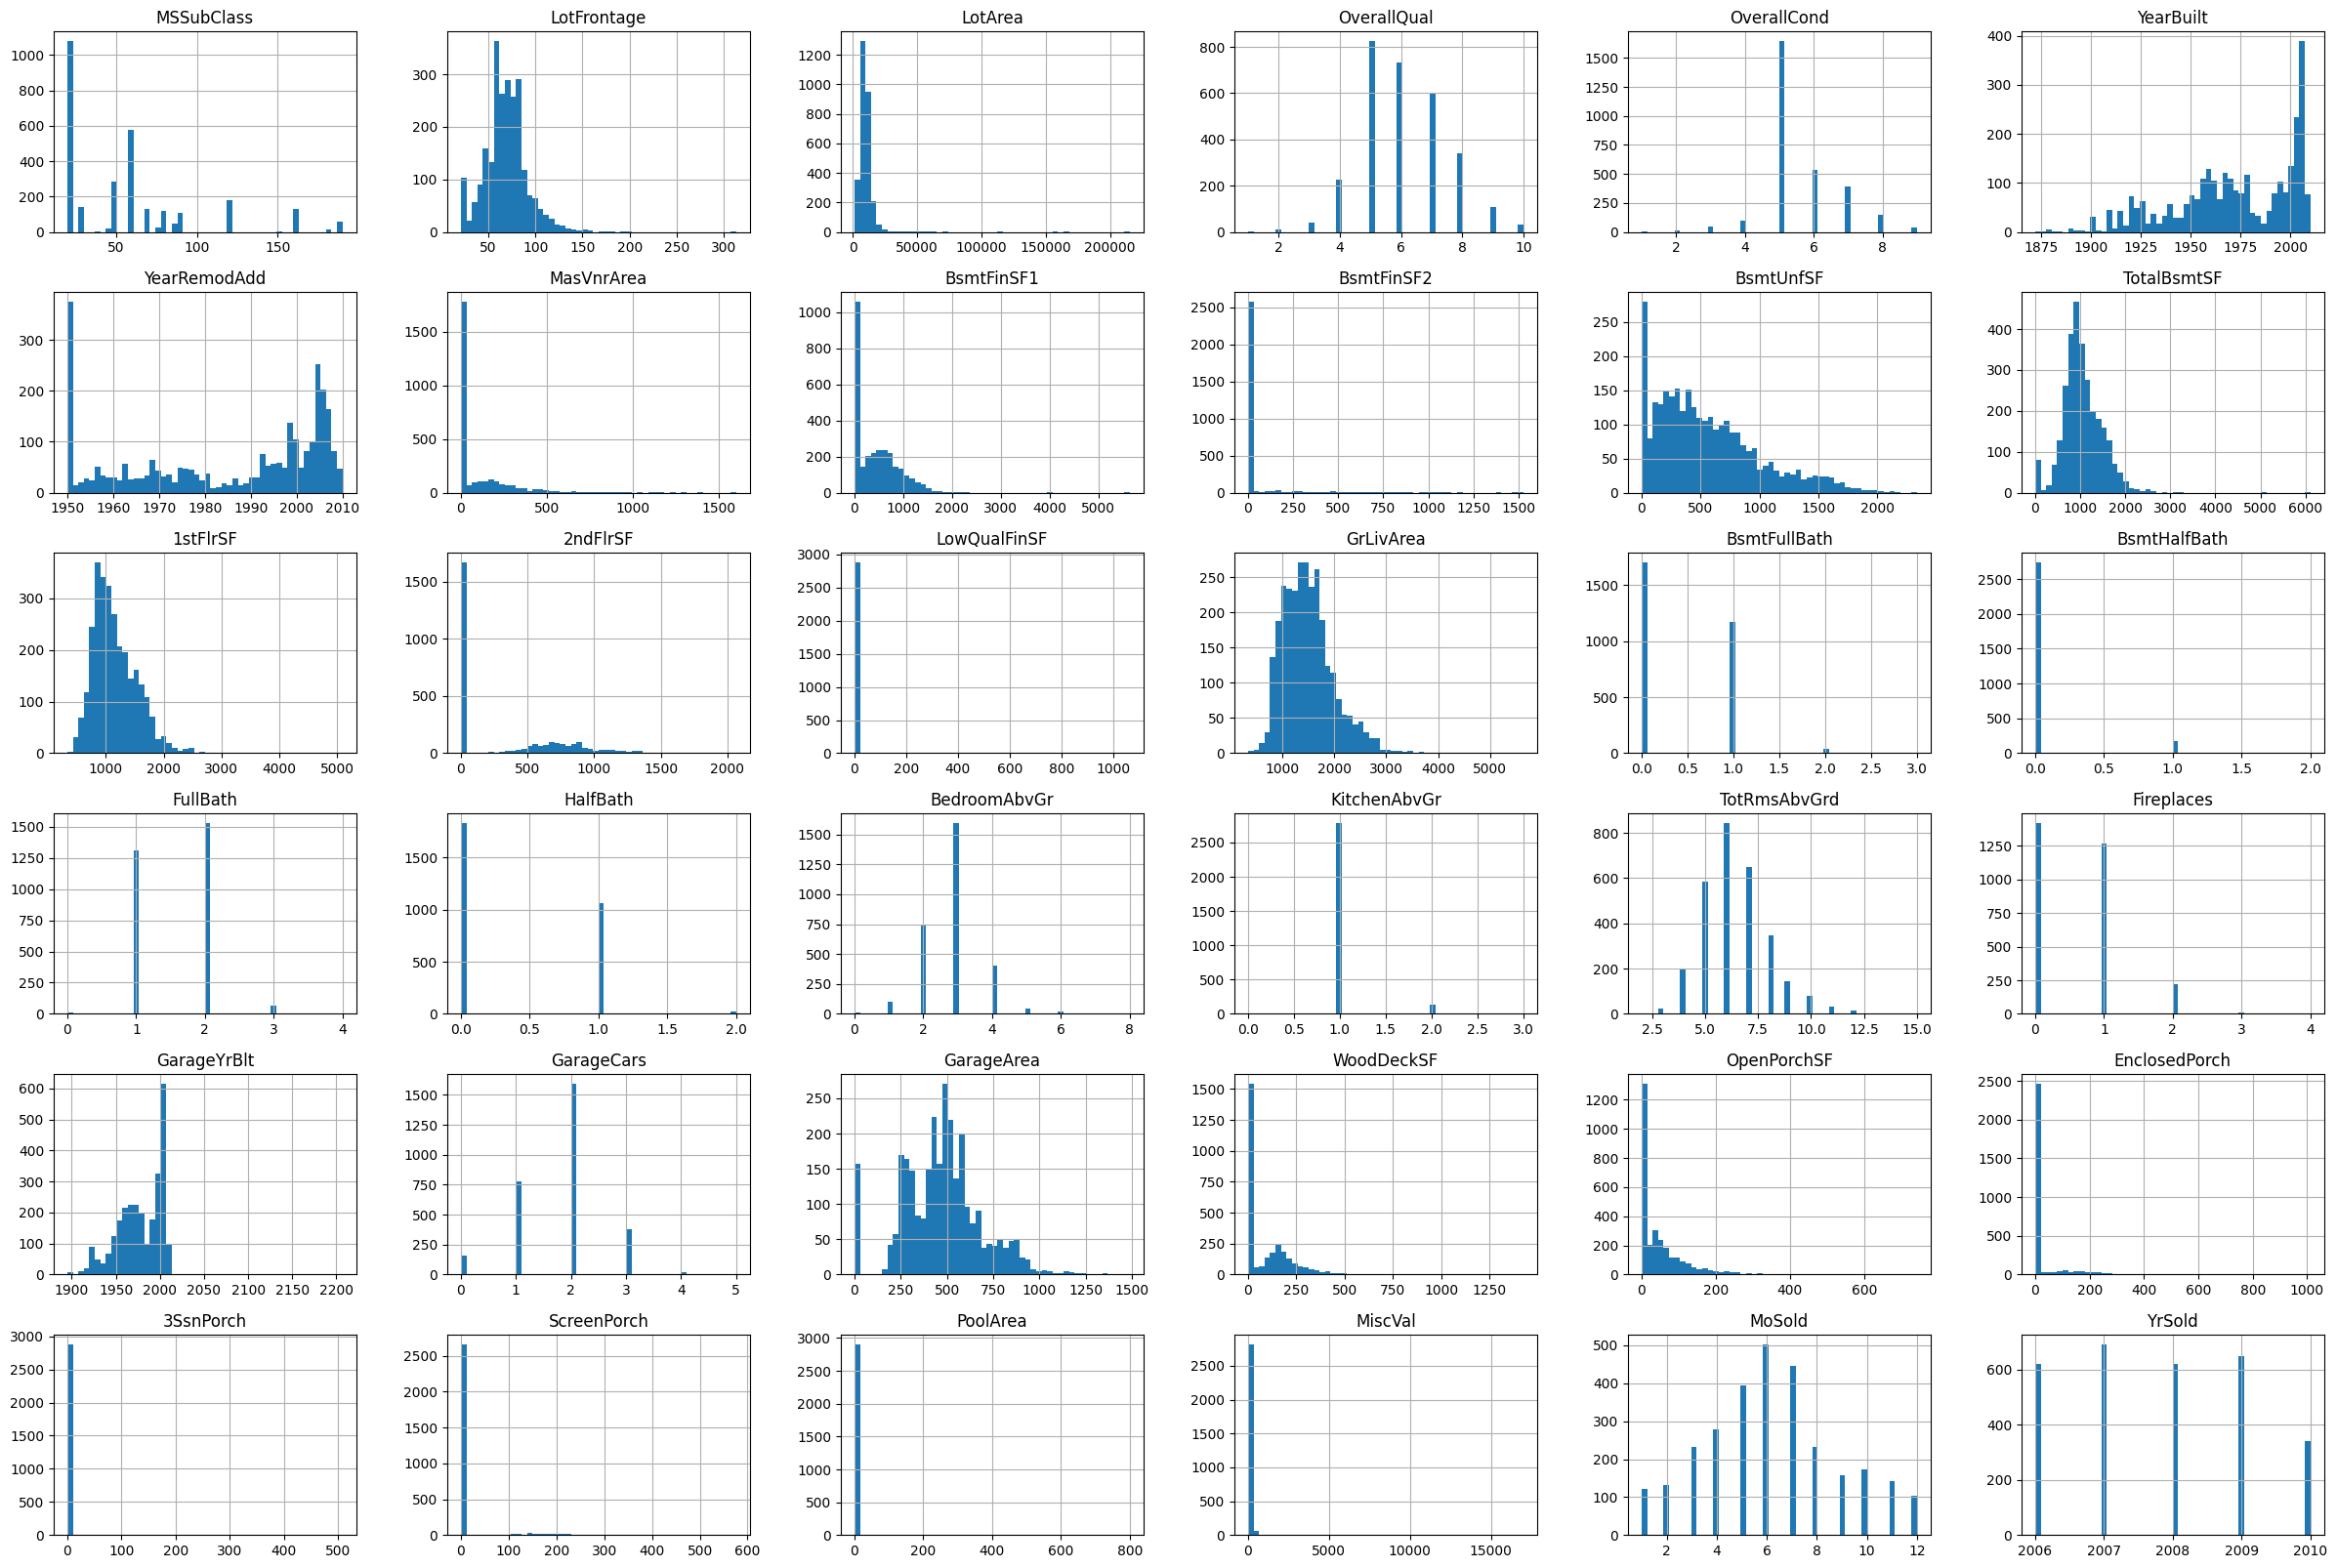

In [128]:
data.drop(columns = "Id").hist(bins = 50, figsize = (30, 20));

## **Data Cleaning**

Let's start by taking a look at our distribution of missing values.

In [90]:
na_prop = data.isna().sum() / len(data)

na_prop.sort_values(ascending = False)[na_prop > 0]

PoolQC          0.996574
MiscFeature     0.964029
Alley           0.932169
Fence           0.804385
FireplaceQu     0.486468
LotFrontage     0.166495
GarageFinish    0.054471
GarageQual      0.054471
GarageCond      0.054471
GarageYrBlt     0.054471
GarageType      0.053786
BsmtExposure    0.028092
BsmtCond        0.028092
BsmtQual        0.027749
BsmtFinType2    0.027407
BsmtFinType1    0.027064
MasVnrType      0.008222
MasVnrArea      0.007879
MSZoning        0.001370
Functional      0.000685
Utilities       0.000685
BsmtHalfBath    0.000685
BsmtFullBath    0.000685
GarageArea      0.000343
BsmtFinSF1      0.000343
SaleType        0.000343
GarageCars      0.000343
BsmtUnfSF       0.000343
Electrical      0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
KitchenQual     0.000343
TotalBsmtSF     0.000343
BsmtFinSF2      0.000343
dtype: float64

After reading the data description provided by Kaggle, I discovered that many variables use NA to indicate that the house does not have a given feature. For example, NA is used to indicate "No pool" for the PoolQC variable. Therefore, we will simply replace NA values with "None" for each of the applicable variables. Similarly, continuous variables for features that are not applicable to the given house will be filled in with 0. 

It seems as if LotFrontage is the only continuous variable that requires a different imputation strategy (since NA doesn't indicate that the house is missing lot frontage!). Also, there are some categorical variables (Eletrical, Utilities) that should also be dealt with in a different manner.

Listed below are the four types (Type 1 - 4) of methods we will use to address missing values in this dataset. 

1. for LotFrontage, we will fill in missing values with the mean of the variable
2. for all categorical variables describing missing features, we will fill in missing values with a new category: "None"
3. for all continuous variables describing missing features, we will fill in missing values with zeroes
4. for the remaining categorical variables, where missing values do not indicate missing features (such as Electrical or Utilities), we will fill in values with the mode of the variable

In [91]:
## Type 1
continuous_missing_columns = ['LotFrontage']

for col in continuous_missing_columns:
    data[col].fillna(value = data[col].mean(), inplace = True)

## Type 2
na_equals_none_columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'GarageType', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'BsmtFinType2', 'BsmtFinType1', 'MasVnrType']

for col in na_equals_none_columns:
    data[col].fillna(value = "None", inplace = True)

## Type 3
na_equals_zero_columns = ['MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath', 'GarageArea', 'BsmtFinSF1', 'GarageCars', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFinSF2']

for col in na_equals_zero_columns:
    data[col].fillna(value = 0, inplace = True)

## Type 4
categorical_missing_columns = ['MSZoning', 'Functional', 'Utilities', 'SaleType', 'Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual']

for col in categorical_missing_columns:
    data[col].fillna(value = stat.mode(data[col]), inplace = True)

Now, let's make sure all of our missing values have been dealt with!

In [92]:
na_prop = data.isna().sum() / len(data)

na_prop.sort_values(ascending = False)[na_prop > 0]

Series([], dtype: float64)

Since everything looks good, we can move on to the next step. In order to perform modeling, we must encode our categorical variables. 

In [96]:
categorical_var = list(data.select_dtypes(exclude='number').columns.values)
categorical_var.extend(['MSSubClass', 'OverallQual', 'OverallCond'])
categorical_var.remove('train')

data = pd.get_dummies(data, columns = categorical_var, drop_first = True)

In [97]:
X = data[data['train'] == "yes"].drop(columns = ['train', 'Id'])
test = data[data['train'] == "no"].drop(columns = ['train'])

## **Statistical Modeling**

Before we begin modeling, let's separate our training data into training and validation sets. The validation set will be used to assess model performance - this is important for hyperparameter tuning!

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, random_state = 8)

Let's fit a few models using the xgboost method. First, we'll use the default hyperparameters. 

In [101]:
dmatrix = xgb.DMatrix(data = X, label = y)

params={'objective':'reg:squarederror'}

cv_results = xgb.cv(dtrain=dmatrix, params=params, nfold=10, metrics={'rmse'}, as_pandas=True, seed=20)

print('RMSE: %.2f' % cv_results['test-rmse-mean'].min())

RMSE: 34240.78


In [109]:
dmatrix.feature_names

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Street_Pave',
 'Alley_None',
 'Alley_Pave',
 'LotShape_IR2',
 'LotShape_IR3',
 'LotShape_Reg',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'Utilities_NoSeWa',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_FR3',
 'LotConfig_Inside',
 'LandSlope_Mod',
 'LandSlope_Sev',
 'Neighborhood_Blueste',
 'Neighborhood_BrDale',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',
 'Neighborhood_Crawfor',
 'Neighborhood_Edward